In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64

# 텍스트(Y / N) 를 0 / 1 값으로 변환시키는 함수
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# x (input data) / y (labels) 로 데이터 전처리해주는 함수
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    if target_type in (np.int64, np.int32):
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)



In [16]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

# 데이터 불러오기
filename1 = os.path.join(path,"f_7data_BCDE.csv")
filename2 = os.path.join(path,"daewoo.csv")
df1 = pd.read_csv(filename1,na_values=['NA','?'])
df2 = pd.read_csv(filename2,na_values=['NA','?'])

# feature vector 인코딩
audit_train = encode_text_index(df1,'audit')
audit_test = encode_text_index(df2,'audit')
num_classes = len(audit_train)

# x, y축 데이터 설정 (훈련데이터셋 & 테스트데이터셋 FIX)
x_train, y_train = to_xy(df1,'audit')
x_test, y_test = to_xy(df2,'audit')
    
# train/test set 분할
#x_train, x_test, y_train, y_test = train_test_split(    
 #   x, y, test_size=0.20, random_state=42) 

# 모델 구성
model = Sequential()
model.add(Dense(25, input_dim=x_train.shape[1], activation='relu')) #뉴런수 25개로 첫번쨰 hidden layer 쌓음
model.add(Dense(5, activation='hard_sigmoid')) #뉴런수 5개로 두번쨰 hidden layer 쌓음
model.add(Dense(y_train.shape[1],activation='softmax')) # label의 크기만큼 output layer 쌓음
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #loss, optimizer, metrics 설정
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=1, mode='auto') #EarlyStopping 기능 (50 epoch 까지는 무조건 학습 진행)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000, batch_size=10)
#train 데이터로 학습시킨 후 test 데이터와 예측값을 비교해 가중치 조정해줌

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=10)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

# 정확도 예측
pred = model.predict(x_test)
proba = model.predict_proba(x_test)
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_compare, pred)
print("Final accuracy: {}".format(score))
proba


Train on 99 samples, validate on 2 samples
Epoch 1/1000
 - 2s - loss: 0.7464 - acc: 0.4141 - val_loss: 0.6560 - val_acc: 0.5000
Epoch 2/1000
 - 0s - loss: 0.7156 - acc: 0.4343 - val_loss: 0.6527 - val_acc: 1.0000
Epoch 3/1000
 - 0s - loss: 0.7035 - acc: 0.4444 - val_loss: 0.6493 - val_acc: 1.0000
Epoch 4/1000
 - 0s - loss: 0.6927 - acc: 0.4545 - val_loss: 0.6467 - val_acc: 1.0000
Epoch 5/1000
 - 0s - loss: 0.6847 - acc: 0.4646 - val_loss: 0.6444 - val_acc: 1.0000
Epoch 6/1000
 - 0s - loss: 0.6754 - acc: 0.4343 - val_loss: 0.5119 - val_acc: 0.5000
Epoch 7/1000
 - 0s - loss: 0.6578 - acc: 0.6364 - val_loss: 0.5119 - val_acc: 0.5000
Epoch 8/1000
 - 0s - loss: 0.6329 - acc: 0.6364 - val_loss: 0.5107 - val_acc: 0.5000
Epoch 9/1000
 - 0s - loss: 0.6317 - acc: 0.6364 - val_loss: 0.5095 - val_acc: 0.5000
Epoch 10/1000
 - 0s - loss: 0.6167 - acc: 0.6465 - val_loss: 0.5086 - val_acc: 0.5000
Epoch 11/1000
 - 0s - loss: 0.6109 - acc: 0.6465 - val_loss: 0.5077 - val_acc: 0.5000
Epoch 12/1000
 - 0s 

Epoch 96/1000
 - 0s - loss: 0.4487 - acc: 0.8485 - val_loss: 0.2961 - val_acc: 1.0000
Epoch 97/1000
 - 0s - loss: 0.4542 - acc: 0.8384 - val_loss: 0.2948 - val_acc: 1.0000
Epoch 98/1000
 - 0s - loss: 0.4361 - acc: 0.8586 - val_loss: 0.2930 - val_acc: 1.0000
Epoch 99/1000
 - 0s - loss: 0.4389 - acc: 0.8485 - val_loss: 0.2910 - val_acc: 1.0000
Epoch 100/1000
 - 0s - loss: 0.4545 - acc: 0.8283 - val_loss: 0.2897 - val_acc: 1.0000
Epoch 101/1000
 - 0s - loss: 0.4451 - acc: 0.8384 - val_loss: 0.2881 - val_acc: 1.0000
Epoch 102/1000
 - 0s - loss: 0.4639 - acc: 0.8283 - val_loss: 0.2863 - val_acc: 1.0000
Epoch 103/1000
 - 0s - loss: 0.4376 - acc: 0.8586 - val_loss: 0.2852 - val_acc: 1.0000
Epoch 104/1000
 - 0s - loss: 0.4336 - acc: 0.8586 - val_loss: 0.2841 - val_acc: 1.0000
Epoch 105/1000
 - 0s - loss: 0.4304 - acc: 0.8586 - val_loss: 0.2827 - val_acc: 1.0000
Epoch 106/1000
 - 0s - loss: 0.4288 - acc: 0.8586 - val_loss: 0.2817 - val_acc: 1.0000
Epoch 107/1000
 - 0s - loss: 0.4288 - acc: 0.85

Epoch 191/1000
 - 0s - loss: 0.4021 - acc: 0.8586 - val_loss: 0.2090 - val_acc: 1.0000
Epoch 192/1000
 - 0s - loss: 0.4044 - acc: 0.8586 - val_loss: 0.2080 - val_acc: 1.0000
Epoch 193/1000
 - 0s - loss: 0.4030 - acc: 0.8687 - val_loss: 0.2070 - val_acc: 1.0000
Epoch 194/1000
 - 0s - loss: 0.4166 - acc: 0.8586 - val_loss: 0.2070 - val_acc: 1.0000
Epoch 195/1000
 - 0s - loss: 0.4119 - acc: 0.8586 - val_loss: 0.2073 - val_acc: 1.0000
Epoch 196/1000
 - 0s - loss: 0.4262 - acc: 0.8384 - val_loss: 0.2065 - val_acc: 1.0000
Epoch 197/1000
 - 0s - loss: 0.4007 - acc: 0.8687 - val_loss: 0.2059 - val_acc: 1.0000
Epoch 198/1000
 - 0s - loss: 0.4019 - acc: 0.8687 - val_loss: 0.2051 - val_acc: 1.0000
Epoch 199/1000
 - 0s - loss: 0.3980 - acc: 0.8687 - val_loss: 0.2053 - val_acc: 1.0000
Epoch 200/1000
 - 0s - loss: 0.3993 - acc: 0.8687 - val_loss: 0.2049 - val_acc: 1.0000
Epoch 201/1000
 - 0s - loss: 0.3909 - acc: 0.8788 - val_loss: 0.2038 - val_acc: 1.0000
Epoch 202/1000
 - 0s - loss: 0.3947 - acc: 

Epoch 286/1000
 - 0s - loss: 0.3597 - acc: 0.8889 - val_loss: 0.1660 - val_acc: 1.0000
Epoch 287/1000
 - 0s - loss: 0.3603 - acc: 0.8889 - val_loss: 0.1655 - val_acc: 1.0000
Epoch 288/1000
 - 0s - loss: 0.3587 - acc: 0.8889 - val_loss: 0.1652 - val_acc: 1.0000
Epoch 289/1000
 - 0s - loss: 0.3553 - acc: 0.8889 - val_loss: 0.1652 - val_acc: 1.0000
Epoch 290/1000
 - 0s - loss: 0.3574 - acc: 0.8889 - val_loss: 0.1647 - val_acc: 1.0000
Epoch 291/1000
 - 0s - loss: 0.3566 - acc: 0.8889 - val_loss: 0.1645 - val_acc: 1.0000
Epoch 292/1000
 - 0s - loss: 0.3546 - acc: 0.8889 - val_loss: 0.1640 - val_acc: 1.0000
Epoch 293/1000
 - 0s - loss: 0.3544 - acc: 0.8889 - val_loss: 0.1638 - val_acc: 1.0000
Epoch 294/1000
 - 0s - loss: 0.3550 - acc: 0.8889 - val_loss: 0.1635 - val_acc: 1.0000
Epoch 295/1000
 - 0s - loss: 0.3542 - acc: 0.8889 - val_loss: 0.1631 - val_acc: 1.0000
Epoch 296/1000
 - 0s - loss: 0.3542 - acc: 0.8889 - val_loss: 0.1628 - val_acc: 1.0000
Epoch 297/1000
 - 0s - loss: 0.3542 - acc: 

Epoch 381/1000
 - 0s - loss: 0.3139 - acc: 0.8889 - val_loss: 0.1251 - val_acc: 1.0000
Epoch 382/1000
 - 0s - loss: 0.3136 - acc: 0.8889 - val_loss: 0.1246 - val_acc: 1.0000
Epoch 383/1000
 - 0s - loss: 0.3135 - acc: 0.8889 - val_loss: 0.1242 - val_acc: 1.0000
Epoch 384/1000
 - 0s - loss: 0.3132 - acc: 0.8889 - val_loss: 0.1238 - val_acc: 1.0000
Epoch 385/1000
 - 0s - loss: 0.3131 - acc: 0.8889 - val_loss: 0.1233 - val_acc: 1.0000
Epoch 386/1000
 - 0s - loss: 0.3128 - acc: 0.8889 - val_loss: 0.1229 - val_acc: 1.0000
Epoch 387/1000
 - 0s - loss: 0.3126 - acc: 0.8889 - val_loss: 0.1225 - val_acc: 1.0000
Epoch 388/1000
 - 0s - loss: 0.3123 - acc: 0.8889 - val_loss: 0.1221 - val_acc: 1.0000
Epoch 389/1000
 - 0s - loss: 0.3132 - acc: 0.8889 - val_loss: 0.1217 - val_acc: 1.0000
Epoch 390/1000
 - 0s - loss: 0.3286 - acc: 0.8788 - val_loss: 0.1212 - val_acc: 1.0000
Epoch 391/1000
 - 0s - loss: 0.3450 - acc: 0.8687 - val_loss: 0.1207 - val_acc: 1.0000
Epoch 392/1000
 - 0s - loss: 0.3485 - acc: 

Epoch 476/1000
 - 0s - loss: 0.2925 - acc: 0.8889 - val_loss: 0.0969 - val_acc: 1.0000
Epoch 477/1000
 - 0s - loss: 0.2924 - acc: 0.8889 - val_loss: 0.0966 - val_acc: 1.0000
Epoch 478/1000
 - 0s - loss: 0.2924 - acc: 0.8889 - val_loss: 0.0964 - val_acc: 1.0000
Epoch 479/1000
 - 0s - loss: 0.2924 - acc: 0.8889 - val_loss: 0.0962 - val_acc: 1.0000
Epoch 480/1000
 - 0s - loss: 0.2922 - acc: 0.8889 - val_loss: 0.0960 - val_acc: 1.0000
Epoch 481/1000
 - 0s - loss: 0.2922 - acc: 0.8889 - val_loss: 0.0957 - val_acc: 1.0000
Epoch 482/1000
 - 0s - loss: 0.2921 - acc: 0.8889 - val_loss: 0.0955 - val_acc: 1.0000
Epoch 483/1000
 - 0s - loss: 0.2922 - acc: 0.8889 - val_loss: 0.0952 - val_acc: 1.0000
Epoch 484/1000
 - 0s - loss: 0.2920 - acc: 0.8889 - val_loss: 0.0951 - val_acc: 1.0000
Epoch 485/1000
 - 0s - loss: 0.2919 - acc: 0.8889 - val_loss: 0.0949 - val_acc: 1.0000
Epoch 486/1000
 - 0s - loss: 0.2919 - acc: 0.8889 - val_loss: 0.0947 - val_acc: 1.0000
Epoch 487/1000
 - 0s - loss: 0.2918 - acc: 

Epoch 571/1000
 - 0s - loss: 0.2891 - acc: 0.8889 - val_loss: 0.0824 - val_acc: 1.0000
Epoch 572/1000
 - 0s - loss: 0.2890 - acc: 0.8889 - val_loss: 0.0822 - val_acc: 1.0000
Epoch 573/1000
 - 0s - loss: 0.2890 - acc: 0.8889 - val_loss: 0.0821 - val_acc: 1.0000
Epoch 574/1000
 - 0s - loss: 0.2889 - acc: 0.8889 - val_loss: 0.0821 - val_acc: 1.0000
Epoch 575/1000
 - 0s - loss: 0.2890 - acc: 0.8889 - val_loss: 0.0820 - val_acc: 1.0000
Epoch 576/1000
 - 0s - loss: 0.2890 - acc: 0.8889 - val_loss: 0.0819 - val_acc: 1.0000
Epoch 577/1000
 - 0s - loss: 0.2889 - acc: 0.8889 - val_loss: 0.0818 - val_acc: 1.0000
Epoch 578/1000
 - 0s - loss: 0.2889 - acc: 0.8889 - val_loss: 0.0817 - val_acc: 1.0000
Epoch 579/1000
 - 0s - loss: 0.2889 - acc: 0.8889 - val_loss: 0.0816 - val_acc: 1.0000
Epoch 580/1000
 - 0s - loss: 0.2889 - acc: 0.8889 - val_loss: 0.0814 - val_acc: 1.0000
Epoch 581/1000
 - 0s - loss: 0.2889 - acc: 0.8889 - val_loss: 0.0814 - val_acc: 1.0000
Epoch 582/1000
 - 0s - loss: 0.2888 - acc: 

 - 0s - loss: 0.2879 - acc: 0.8889 - val_loss: 0.0748 - val_acc: 1.0000
Epoch 666/1000
 - 0s - loss: 0.2878 - acc: 0.8889 - val_loss: 0.0748 - val_acc: 1.0000
Epoch 667/1000
 - 0s - loss: 0.2879 - acc: 0.8889 - val_loss: 0.0748 - val_acc: 1.0000
Epoch 668/1000
 - 0s - loss: 0.2878 - acc: 0.8889 - val_loss: 0.0747 - val_acc: 1.0000
Epoch 669/1000
 - 0s - loss: 0.2878 - acc: 0.8889 - val_loss: 0.0746 - val_acc: 1.0000
Epoch 670/1000
 - 0s - loss: 0.2878 - acc: 0.8889 - val_loss: 0.0745 - val_acc: 1.0000
Epoch 671/1000
 - 0s - loss: 0.2878 - acc: 0.8889 - val_loss: 0.0744 - val_acc: 1.0000
Epoch 672/1000
 - 0s - loss: 0.2878 - acc: 0.8889 - val_loss: 0.0744 - val_acc: 1.0000
Epoch 673/1000
 - 0s - loss: 0.2878 - acc: 0.8889 - val_loss: 0.0743 - val_acc: 1.0000
Epoch 674/1000
 - 0s - loss: 0.2878 - acc: 0.8889 - val_loss: 0.0743 - val_acc: 1.0000
Epoch 675/1000
 - 0s - loss: 0.2877 - acc: 0.8889 - val_loss: 0.0743 - val_acc: 1.0000
Epoch 676/1000
 - 0s - loss: 0.2878 - acc: 0.8889 - val_lo

Epoch 760/1000
 - 0s - loss: 0.2873 - acc: 0.8889 - val_loss: 0.0701 - val_acc: 1.0000
Epoch 761/1000
 - 0s - loss: 0.2874 - acc: 0.8889 - val_loss: 0.0701 - val_acc: 1.0000
Epoch 762/1000
 - 0s - loss: 0.2874 - acc: 0.8889 - val_loss: 0.0701 - val_acc: 1.0000
Epoch 763/1000
 - 0s - loss: 0.2873 - acc: 0.8889 - val_loss: 0.0700 - val_acc: 1.0000
Epoch 764/1000
 - 0s - loss: 0.2874 - acc: 0.8889 - val_loss: 0.0700 - val_acc: 1.0000
Epoch 765/1000
 - 0s - loss: 0.2874 - acc: 0.8889 - val_loss: 0.0700 - val_acc: 1.0000
Epoch 766/1000
 - 0s - loss: 0.2873 - acc: 0.8889 - val_loss: 0.0699 - val_acc: 1.0000
Epoch 767/1000
 - 0s - loss: 0.2875 - acc: 0.8889 - val_loss: 0.0699 - val_acc: 1.0000
Epoch 768/1000
 - 0s - loss: 0.2873 - acc: 0.8889 - val_loss: 0.0699 - val_acc: 1.0000
Epoch 769/1000
 - 0s - loss: 0.2874 - acc: 0.8889 - val_loss: 0.0699 - val_acc: 1.0000
Epoch 770/1000
 - 0s - loss: 0.2873 - acc: 0.8889 - val_loss: 0.0698 - val_acc: 1.0000
Epoch 771/1000
 - 0s - loss: 0.2873 - acc: 

 - 0s - loss: 0.2873 - acc: 0.8889 - val_loss: 0.0672 - val_acc: 1.0000
Epoch 855/1000
 - 0s - loss: 0.2873 - acc: 0.8889 - val_loss: 0.0672 - val_acc: 1.0000
Epoch 856/1000
 - 0s - loss: 0.2871 - acc: 0.8889 - val_loss: 0.0671 - val_acc: 1.0000
Epoch 857/1000
 - 0s - loss: 0.2870 - acc: 0.8889 - val_loss: 0.0671 - val_acc: 1.0000
Epoch 858/1000
 - 0s - loss: 0.2870 - acc: 0.8889 - val_loss: 0.0671 - val_acc: 1.0000
Epoch 859/1000
 - 0s - loss: 0.2871 - acc: 0.8889 - val_loss: 0.0670 - val_acc: 1.0000
Epoch 860/1000
 - 0s - loss: 0.2871 - acc: 0.8889 - val_loss: 0.0670 - val_acc: 1.0000
Epoch 861/1000
 - 0s - loss: 0.2871 - acc: 0.8889 - val_loss: 0.0670 - val_acc: 1.0000
Epoch 862/1000
 - 0s - loss: 0.2872 - acc: 0.8889 - val_loss: 0.0669 - val_acc: 1.0000
Epoch 863/1000
 - 0s - loss: 0.2871 - acc: 0.8889 - val_loss: 0.0669 - val_acc: 1.0000
Epoch 864/1000
 - 0s - loss: 0.2871 - acc: 0.8889 - val_loss: 0.0669 - val_acc: 1.0000
Epoch 865/1000
 - 0s - loss: 0.2870 - acc: 0.8889 - val_lo

Epoch 949/1000
 - 0s - loss: 0.2869 - acc: 0.8889 - val_loss: 0.0651 - val_acc: 1.0000
Epoch 950/1000
 - 0s - loss: 0.2872 - acc: 0.8889 - val_loss: 0.0650 - val_acc: 1.0000
Epoch 951/1000
 - 0s - loss: 0.2870 - acc: 0.8889 - val_loss: 0.0651 - val_acc: 1.0000
Epoch 00951: early stopping
2/2 [==============================] - 0s 2ms/step
## evaluation loss and_metrics ##
[0.06506213545799255, 1.0]
Final accuracy: 1.0


array([[0.08, 0.92],
       [0.95, 0.05]], dtype=float32)

In [17]:

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#confusion matrix의 프레임 설정
# cm -> confusion matrix / names -> 각 클래스의 이름
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Confusion matrix
[[1 0]
 [0 1]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


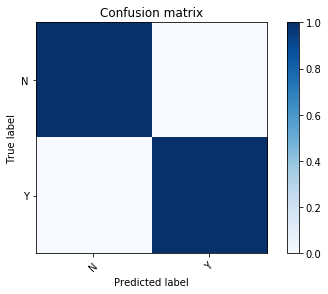

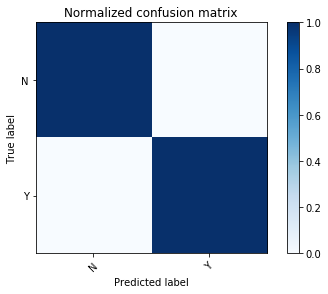

In [18]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# 예측한 label을 실제 label과 숫자로 비교한 confusion matrix
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm, audit_test)

# 예측한 label을 실제 label과 확률로 비교한 confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, audit_test, title='Normalized confusion matrix')

plt.show()




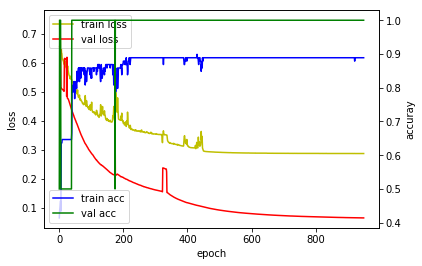

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# epoch 증가에 따른 accuracy와 loss 크기의 변화 추이 확인
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()